In [1]:
!python -m spacy download en_core_web_sm

  Using cached https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.7.1/en_core_web_sm-3.7.1-py3-none-any.whl (12.8 MB)
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip available: 22.3.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# model_requirements:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import transformers as tr

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# math_and_basic_requirements:
import numpy as np
from collections import defaultdict
from collections import  Counter

# analytic_requirements:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# language_requirements:
import re
import string
import spacy

# misc:
import warnings
warnings.filterwarnings('ignore')
import tqdm as tqdm
import os
from textwrap import wrap

c:\Users\mohsi\OneDrive\Desktop\Aspect-Based-Sentiment-Extraction\absa\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nlp=spacy.load('en_core_web_sm')

In [4]:
os.getcwd()

'c:\\Users\\mohsi\\OneDrive\\Desktop\\Aspect-Based-Sentiment-Extraction\\notebooks'

In [5]:
path = os.getcwd()[:-10]

In [6]:
path  # path to the absa folder

'c:\\Users\\mohsi\\OneDrive\\Desktop\\Aspect-Based-Sentiment-Extraction'

In [7]:
# configuration class for hyperparameters and other configurations

class Config:

      def __init__(self):

        # general hyperparameters
        self.MAX_LEN = 250
        self.BATCH_SIZE = 4
        self.EPOCHS = 20
        self.learning_rate = 0.00001
        
        # train, val and test split ratios (when using train_test_split of scikit learn)
        self.TRAIN_VAL_SPLIT = 0.3
        self.VAL_TEST_SPLIT = 0.5

        # paths
        #self.path = os.getcwd()[:-10]
        self.data_path = f'{path}/data'
        self.train_file_path = f'{path}/data/train.csv'
        self.test_file_path = f'{path}/data/results/test.csv'
        self.model_save_path = f'{path}/models'
        self.results_save_path = f'{path}/data/results'

        # model types
        self.bert_base_model = True # if want to use the BertModel, otherwise DistilBertModel
        self.case_based_model = True # if want to use the cased or uncased version

        # others
        self.num_workers = 0
        self.RANDOM_SEED = 43
        self.train_shuffle = True
        self.valid_shuffle = False
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
conf = Config()
print(conf.data_path)

c:\Users\mohsi\OneDrive\Desktop\Aspect-Based-Sentiment-Extraction/data


## Exploration

In [9]:
# reading the training and the testing files
train_df = pd.read_csv(conf.train_file_path)
test_df = pd.read_csv(conf.test_file_path)

In [10]:
# to make dataframe take up the whole width of the screen
pd.set_option('display.max_colwidth', None) 

In [11]:
train_df.head()

,text,aspect,label
0,can you check whether its cancelled completely?,cancelled,1
1,cannot rely on both milk delivery and grocery items.,Milk,0
2,"I get no notification, however the app is really fine",notification,0
3,"Love this app, but would love it even more if Gantt charts and Calendar view were available on iPhone!",view,1
4,it does not let me load a clip on the scene,load,0


In [12]:
train_df['label'].value_counts()

label
0    1680
1    1294
2    1026
Name: count, dtype: int64

In [13]:
test_df.head()

,text,aspect
0,improve your customer service and product availability,Customer service
1,"functionality is great, almost as in desktop version, but mobile version needs a lot of improvement esp the speed",mobile version
2,but it keeps starting from zoomed in and then slowly zooming out as the music plays.,zoomed
3,hey marilyn thanks for your answer the soc2 type 1 certification is a document that can be shared with external parties for security assessment do you have a copy of the report we could explore?,Security
4,@delanovc @zoom @airtable @notionhq @calendly apple x lulu would be the most interesting if they ever expand their.,apple


In [14]:
print(f'Size of the train data: {len(train_df)}')
print(f'Size of test data: {len(test_df)}')

Size of the train data: 4000
Size of test data: 1000


[Text(0, 0, 'Negative: 1680'),
 Text(1, 0, 'Neutral: 1294'),
 Text(2, 0, 'Positive: 1026')]

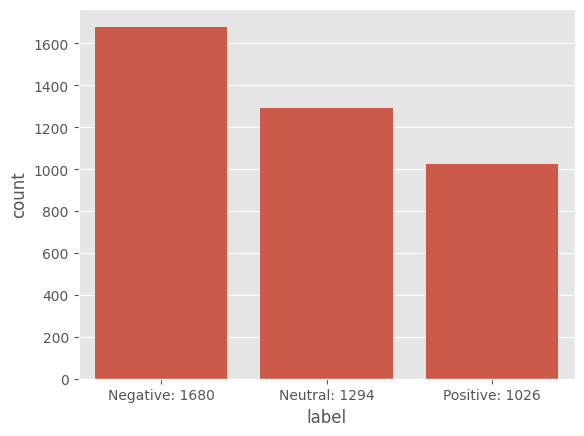

In [15]:
# class distribution of positive and negative classes
ax=sns.countplot(x='label',data=train_df)
ax.set_xticklabels([f'Negative: {len(train_df.loc[train_df["label"]==0])}',f'Neutral: {len(train_df.loc[train_df["label"]==1])}', f'Positive: {len(train_df.loc[train_df["label"]==2])}'])


In [16]:
# are there any null rows in train data
null_train_entries=train_df['text'].isnull().sum()
print(null_train_entries)
print(f'{null_train_entries/len(train_df)*100:.2f} % of keyowrds values are missing in train data')
print()

# are there any null rows in test data
null_test_entries=test_df['text'].isnull().sum()
print(null_test_entries)
print(f'{null_test_entries/len(test_df)*100:.2f} % of keyowrds values are missing in test data')

0
0.00 % of keyowrds values are missing in train data

0
0.00 % of keyowrds values are missing in test data


#### Analyzing stop words and punctuations

In [17]:
# create temporary corpus for analysing punctuations and stopwords:
def temporary_corpus(target):
    corpus=[]
    
    for text in train_df[train_df['label']==target]['text'].str.split():
        for i in text:
            corpus.append(i)
    return corpus

##### Punctuations

In [18]:
# special

<BarContainer object of 23 artists>

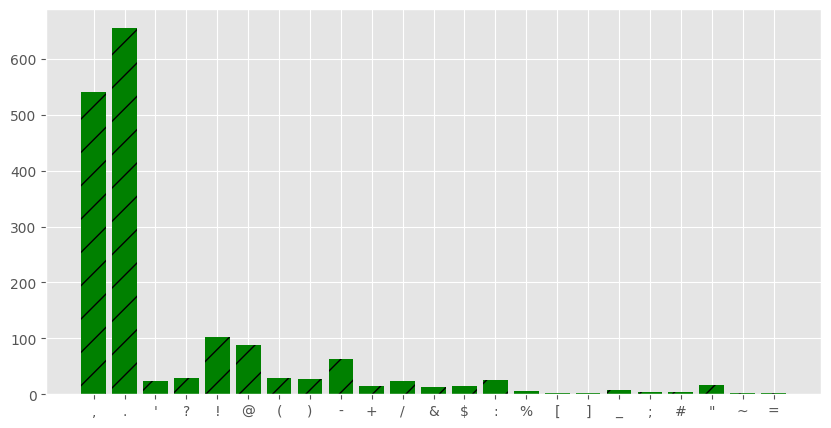

In [19]:
# analyzing punctuation for Positive(2) sentiment class:
plt.figure(figsize=(10,5))
corpus=temporary_corpus(2)

dic=defaultdict(int) # dictionary where missing keys are automatically initialized to 0
special = string.punctuation
for token in corpus:
    for character in token:
        if character in special:
            dic[character]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='g', hatch='/')

<BarContainer object of 28 artists>

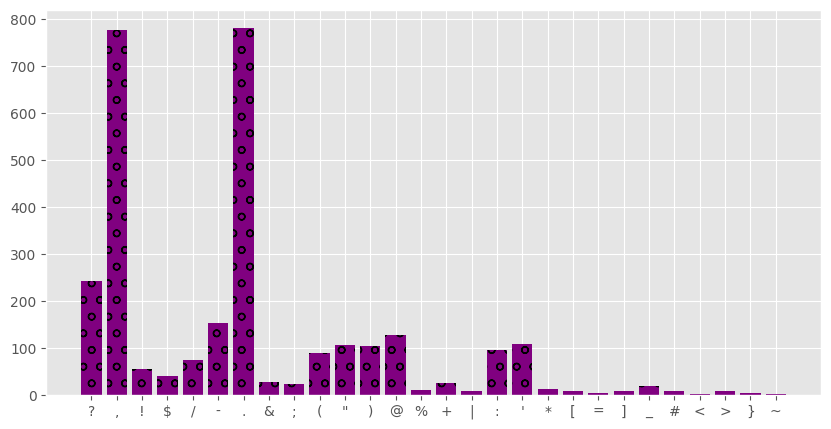

In [20]:
# analyzing punctuation for Negative (1) sentiment class:
plt.figure(figsize=(10,5))
corpus=temporary_corpus(1)

dic=defaultdict(int)
special = string.punctuation
for token in corpus:
    for character in token:
        if character in special:
            dic[character]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='purple', hatch='o')

<BarContainer object of 28 artists>

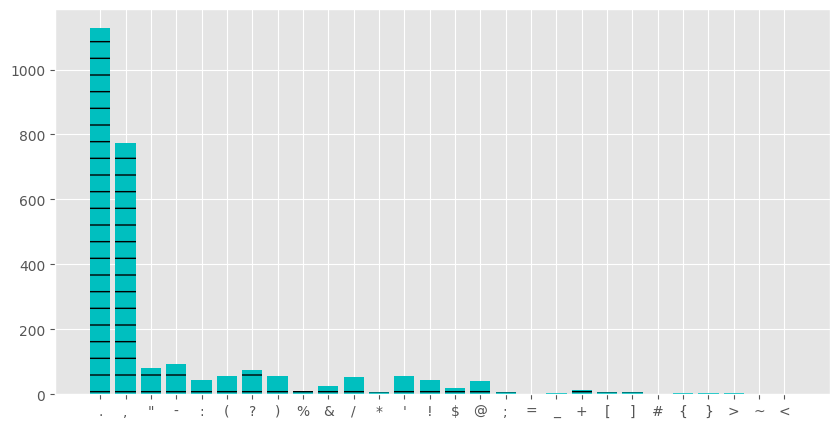

In [21]:
# analyzing punctuation for Neutral (0) sentiment class:
plt.figure(figsize=(10,5))
corpus=temporary_corpus(0)

dic=defaultdict(int)
special = string.punctuation
for token in corpus:
    for character in token:
        if character in special:
            dic[character]+=1
        
x,y=zip(*dic.items())
plt.bar(x,y, color='c', hatch='-')

##### Stop words

In [22]:
def frequent_stopwords(label):
    corpus=temporary_corpus(label)

    dic=defaultdict(int)
    for word in corpus:
        if word in nlp.Defaults.stop_words:
            dic[word]+=1

    # getting the top 10 most frequent stop words        
    top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10]

    return top, dic

In [23]:
# stop words for positive class
top, dic = frequent_stopwords(2)

In [24]:
 dic #dictionary containing stop word counts in postive class

defaultdict(int,
            {'i': 239,
             'as': 60,
             'a': 197,
             'but': 110,
             'the': 469,
             'just': 43,
             'too': 14,
             'to': 351,
             'please': 19,
             'this': 145,
             'is': 282,
             'and': 383,
             'of': 169,
             'part': 2,
             'can': 73,
             'when': 19,
             'not': 81,
             'it': 197,
             'only': 13,
             'has': 52,
             'become': 3,
             'what': 21,
             'could': 16,
             'well': 16,
             'am': 29,
             'about': 16,
             'in': 105,
             'which': 18,
             'you': 123,
             'on': 139,
             'something': 3,
             'for': 217,
             'will': 33,
             'out': 19,
             'by': 17,
             'itself': 6,
             'everything': 9,
             'have': 93,
             'such': 4,
             '

In [25]:
top

[('the', 469),
 ('and', 383),
 ('to', 351),
 ('is', 282),
 ('i', 239),
 ('for', 217),
 ('a', 197),
 ('it', 197),
 ('of', 169),
 ('this', 145)]

In [26]:
print(f'Total number of stop words in spacy: {len(nlp.Defaults.stop_words)}')
print(f'Total number of stop words in our disaster class which are part of the spacy\'s stop words list: {len(dic)}')


Total number of stop words in spacy: 326
Total number of stop words in our disaster class which are part of the spacy's stop words list: 204


<BarContainer object of 10 artists>

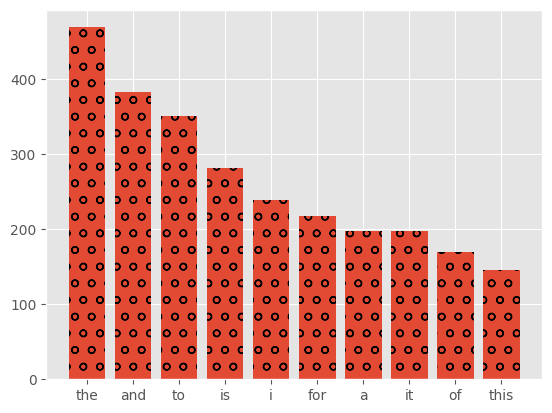

In [27]:
# top 10 most frequent stop words in our corpus:
x,y=zip(*top)
plt.bar(x,y, hatch='o')

In [28]:
# stop words for negative class
top, dic = frequent_stopwords(1)

In [29]:
print(f'Total number of stop words in spacy: {len(nlp.Defaults.stop_words)}')
print(f'Total number of stop words in our disaster class which are part of the spacy\'s stop words list: {len(dic)}')

Total number of stop words in spacy: 326
Total number of stop words in our disaster class which are part of the spacy's stop words list: 222


<BarContainer object of 10 artists>

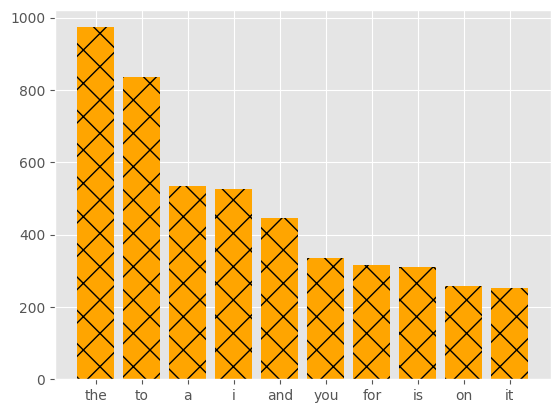

In [30]:
# top 10 most frequent stop words in our corpus:
x,y=zip(*top)
plt.bar(x,y, color='orange', hatch='x')

In [31]:
# stop words for neutral class
top, dic = frequent_stopwords(0)

In [32]:
top

[('the', 998),
 ('to', 629),
 ('and', 519),
 ('is', 515),
 ('i', 450),
 ('not', 426),
 ('a', 382),
 ('of', 353),
 ('it', 338),
 ('on', 307)]

In [33]:
print(f'Total number of stop words in spacy: {len(nlp.Defaults.stop_words)}')
print(f'Total number of stop words in our disaster class which are part of the spacy\'s stop words list: {len(dic)}')

Total number of stop words in spacy: 326
Total number of stop words in our disaster class which are part of the spacy's stop words list: 227


<BarContainer object of 10 artists>

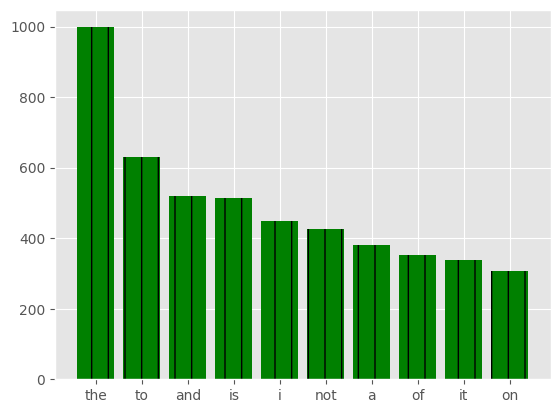

In [34]:
# top 10 most frequent stop words in our corpus:
x,y=zip(*top)
plt.bar(x,y, color='green', hatch='|')

In [35]:
feature = 'mention_count'
train_df[feature] = train_df['text'].apply(lambda x: len([ch for ch in str(x) if ch == '@']))
test_df[feature] = test_df['text'].apply(lambda x: len([ch for ch in str(x) if ch == '@']))

In [36]:
print(len(train_df[feature].unique()))
print(len(test_df[feature].unique()))

8
6


In [37]:
feature='count_of_hashtags'
train_df[feature] = train_df['text'].apply(lambda x: len([ch for ch in str(x) if ch == '#']))
test_df[feature] = test_df['text'].apply(lambda x: len([ch for ch in str(x) if ch == '#']))

In [38]:
print(len(train_df[feature].unique()))
print(len(test_df[feature].unique()))

3
3


In [39]:
feature='count_of_urls'
train_df[feature] = train_df['text'].apply(lambda x: len([word for word in str(x).lower().split() if 'http' in word or 'https' in word]))
test_df[feature] = test_df['text'].apply(lambda x: len([word for word in str(x).lower().split() if 'http' in word or 'https' in word]))

In [40]:
print(len(train_df[feature].unique()))
print(len(test_df[feature].unique()))

1
1


In [41]:
print(train_df['aspect'].unique().shape)
print(test_df['aspect'].unique().shape)

(1544,)
(558,)


In [42]:
# minor preprocessing of the text
def preprocess_text(doc):
    
    # removing the URLs
    url_pattern = r'\S*https?:\S*'
    data = re.sub(url_pattern,'',doc)

    # removing the usernames:
    username_pattern = r'@[^\s]+'
    data = re.sub(username_pattern,'',data)

    # remove special characters 
    special_chars = r'[^\w\s]|_'
    data = re.sub(special_chars, '', data)

    # remving patterns in square brackets
    sq_bracks_pat = r'\[.*?\]'
    data = re.sub(sq_bracks_pat, '', data)

    # removing unwanted html tags
    html_pattern = r'<.*?>+'
    data = re.sub(html_pattern, '', data)

    return data

In [43]:
# applying preprocessing to both the train and the test data text column
train_df['cleaned_text']=train_df['text'].apply(lambda text:preprocess_text(text))
test_df['cleaned_text']=test_df['text'].apply(lambda text:preprocess_text(text))

In [44]:
train_df.head()

,text,aspect,label,mention_count,count_of_hashtags,count_of_urls,cleaned_text
0,can you check whether its cancelled completely?,cancelled,1,0,0,0,can you check whether its cancelled completely
1,cannot rely on both milk delivery and grocery items.,Milk,0,0,0,0,cannot rely on both milk delivery and grocery items
2,"I get no notification, however the app is really fine",notification,0,0,0,0,I get no notification however the app is really fine
3,"Love this app, but would love it even more if Gantt charts and Calendar view were available on iPhone!",view,1,0,0,0,Love this app but would love it even more if Gantt charts and Calendar view were available on iPhone
4,it does not let me load a clip on the scene,load,0,0,0,0,it does not let me load a clip on the scene


In [45]:
# applying preprocessing to both the train and the test data aspect column
train_df['cleaned_aspect']=train_df['aspect'].apply(lambda text:preprocess_text(text))
test_df['cleaned_aspect']=test_df['aspect'].apply(lambda text:preprocess_text(text))

In [46]:
train_df.head()

,text,aspect,label,mention_count,count_of_hashtags,count_of_urls,cleaned_text,cleaned_aspect
0,can you check whether its cancelled completely?,cancelled,1,0,0,0,can you check whether its cancelled completely,cancelled
1,cannot rely on both milk delivery and grocery items.,Milk,0,0,0,0,cannot rely on both milk delivery and grocery items,Milk
2,"I get no notification, however the app is really fine",notification,0,0,0,0,I get no notification however the app is really fine,notification
3,"Love this app, but would love it even more if Gantt charts and Calendar view were available on iPhone!",view,1,0,0,0,Love this app but would love it even more if Gantt charts and Calendar view were available on iPhone,view
4,it does not let me load a clip on the scene,load,0,0,0,0,it does not let me load a clip on the scene,load


In [47]:
test_df.head()

,text,aspect,mention_count,count_of_hashtags,count_of_urls,cleaned_text,cleaned_aspect
0,improve your customer service and product availability,Customer service,0,0,0,improve your customer service and product availability,Customer service
1,"functionality is great, almost as in desktop version, but mobile version needs a lot of improvement esp the speed",mobile version,0,0,0,functionality is great almost as in desktop version but mobile version needs a lot of improvement esp the speed,mobile version
2,but it keeps starting from zoomed in and then slowly zooming out as the music plays.,zoomed,0,0,0,but it keeps starting from zoomed in and then slowly zooming out as the music plays,zoomed
3,hey marilyn thanks for your answer the soc2 type 1 certification is a document that can be shared with external parties for security assessment do you have a copy of the report we could explore?,Security,0,0,0,hey marilyn thanks for your answer the soc2 type 1 certification is a document that can be shared with external parties for security assessment do you have a copy of the report we could explore,Security
4,@delanovc @zoom @airtable @notionhq @calendly apple x lulu would be the most interesting if they ever expand their.,apple,5,0,0,apple x lulu would be the most interesting if they ever expand their,apple


In [48]:
train_df = train_df[['text', 'aspect', 'cleaned_text', 'cleaned_aspect', 'label']] # selecting only the relevant columns
test_df = test_df[['text', 'aspect', 'cleaned_text', 'cleaned_aspect']]

In [49]:
train_df.head()

,text,aspect,cleaned_text,cleaned_aspect,label
0,can you check whether its cancelled completely?,cancelled,can you check whether its cancelled completely,cancelled,1
1,cannot rely on both milk delivery and grocery items.,Milk,cannot rely on both milk delivery and grocery items,Milk,0
2,"I get no notification, however the app is really fine",notification,I get no notification however the app is really fine,notification,0
3,"Love this app, but would love it even more if Gantt charts and Calendar view were available on iPhone!",view,Love this app but would love it even more if Gantt charts and Calendar view were available on iPhone,view,1
4,it does not let me load a clip on the scene,load,it does not let me load a clip on the scene,load,0


In [50]:
max(train_df['cleaned_text'].apply(lambda txt: len(txt)))

1446

In [51]:
max(test_df['cleaned_text'].apply(lambda txt : len(txt)))

1627

In [52]:
# maximum length of the text present in the given dataset
max_len=max(max(train_df['cleaned_text'].apply(lambda txt : len(txt))), max(test_df['cleaned_text'].apply(lambda txt : len(txt))))
max_len

1627

## Using BERT For Our Task

In [53]:
clean_train_path = 'C:\\Users\\mohsi\\OneDrive\\Desktop\\Aspect-Based-Sentiment-Extraction\\data\\clean_train.csv'
clean_test_path = 'C:\\Users\mohsi\\OneDrive\Desktop\\Aspect-Based-Sentiment-Extraction\\data\\clean_test.csv'

In [54]:
train_df = pd.read_csv(clean_train_path)
#test_df = pd.read_csv(clean_test_path)

In [55]:
import transformers as tr

In [56]:
#model_class, tokenizer_class, pretrained_weights = (tr.DistilBertModel, tr.DistilBertTokenizer, 'distilbert-base-uncased')

## For regular BERT:
model_class, tokenizer_class, pretrained_weights = (tr.BertModel, tr.BertTokenizer, 'bert-base-cased')

# Load pretrained model/tokenizer
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
#model = model_class.from_pretrained(pretrained_weights)

In [57]:
tokens = tokenizer.encode("Hello, how are you?", max_length=512, truncation=True)
tokens

[101, 8667, 117, 1293, 1132, 1128, 136, 102]

In [58]:
# for distribution of the length of the tokens of train data text

import logging
logging.basicConfig(level=logging.ERROR) 

train_token_lens = []
for txt in train_df.cleaned_text:
    tokens = tokenizer.encode(txt, max_length = 512)
    train_token_lens.append(len(tokens))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


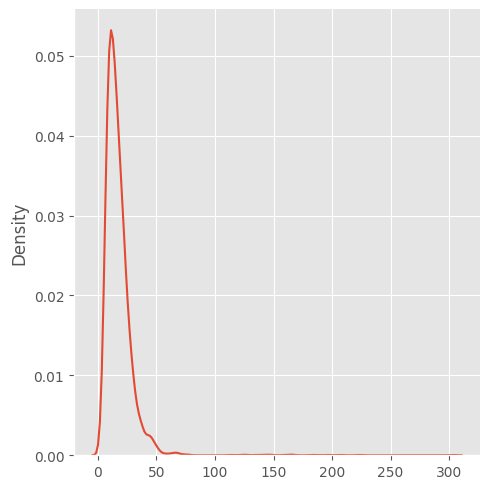

In [59]:
sns.displot(train_token_lens, kind='kde')

In [60]:
max(train_token_lens)

303

In [61]:
# for distribution of the length of the tokens of test data text

logging.basicConfig(level=logging.ERROR)

test_token_lens = []
for txt in test_df['cleaned_text']:
    tokens = tokenizer.encode(txt, max_length = 512)
    test_token_lens.append(len(tokens))

<Axes: ylabel='Count'>

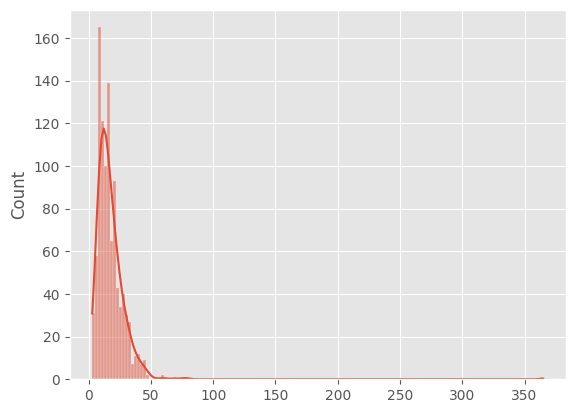

In [62]:
sns.histplot(test_token_lens, kde=True)

In [63]:
max(test_token_lens)

365

In [64]:
# building up the custom dataset class for our datset
class ABSA_Dataset(Dataset):
    def __init__(self, texts, aspects, targets, tokenizer, max_len):
        self.texts = texts
        self.aspects = aspects
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len


    def __len__(self):
        return len(self.texts)


    def __getitem__(self, index):
        text = str(self.texts[index])
        aspect = str(self.aspects[index])
        target = self.targets[index]
        
        encoding = self.tokenizer(
          text,
          aspect,
          add_special_tokens = True,
          max_length = self.max_len,
          return_token_type_ids = False,
          padding = 'max_length',
          truncation = True,
          return_attention_mask = True,
          return_tensors = 'pt',
        )

        return {
          'text': text,
          'aspect': aspect,
          'input_ids': encoding['input_ids'].flatten(),  # from torch.Size([1,max_len]) to torch.Size([max_len])
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [65]:
def regular_train_test_split(train_df):
    
    df_train, df_test = train_test_split(
      train_df,
      test_size=conf.TRAIN_VAL_SPLIT,
      random_state=conf.RANDOM_SEED
    )

    df_val, df_test = train_test_split(
      df_test,
      test_size=conf.VAL_TEST_SPLIT,
      random_state=conf.RANDOM_SEED
    )
    
    return df_train, df_val, df_test

In [66]:
def define_folds(df):
    
    df["kfold"] = -1
    df = df.sample(frac=1).reset_index(drop=True)
    y = df.label.values
    kf = model_selection.StratifiedKFold(n_splits=5)
    
    for f, (t_, v_) in enumerate(kf.split(X=df, y=y)):
        df.loc[v_, 'kfold'] = f
    
    df.to_csv(f'{conf.data_path}/train_folds.csv', index=False)
        
    return df

In [67]:
train_df = define_folds(train_df)

In [68]:
train_df

,text,aspect,cleaned_text,cleaned_aspect,label,kfold
0,introduction of delivery fees per pack of milk delivery paves way for customers to buy directly from shops or milk vendor delivery,delivery fees,introduction of delivery fees per pack of milk delivery paves way for customers to buy directly from shops or milk vendor delivery,delivery fees,0,0
1,"notion evolution templates and videos #notion, @notionhq, #productivity",Templates,notion evolution templates and videos notion productivity,Templates,2,0
2,"ah-ha, i am talking about like 10 usd here:)",USD,ahha i am talking about like 10 usd here,USD,1,0
3,"hi, thamirys sorry about this, we just updated to the latest version of katex to add support for more amsthm environments that might affect some structure including the color.",color,hi thamirys sorry about this we just updated to the latest version of katex to add support for more amsthm environments that might affect some structure including the color,color,0,0
4,"exelent app, it has helped me get all of my notes and ideas in place.",notes,exelent app it has helped me get all of my notes and ideas in place,notes,2,0
...,...,...,...,...,...,...
3995,"but allows me to quickly check my pages, my other wish would be that it load faster.",load,but allows me to quickly check my pages my other wish would be that it load faster,load,0,4
3996,i uv received rotten vegetables and fruits and stale bread.,fruits,i uv received rotten vegetables and fruits and stale bread,fruits,0,4
3997,no customization on toolbar.,customization,no customization on toolbar,customization,0,4
3998,"great app, but can sometimes take too long to load (5s +).",load,great app but can sometimes take too long to load 5s,load,0,4


In [69]:
fold = 0

In [70]:
df_train = train_df[train_df['kfold'] != fold]
df_val = train_df[train_df['kfold'] == fold]

In [71]:
# function for creating dataloaders for train and test datasets

def create_dataloader(df, tokenizer, max_len, batch_size, shuffle=False):
    
    dataset = ABSA_Dataset(
        texts = df.cleaned_text.to_numpy(),
        aspects = df.cleaned_aspect.to_numpy(),
        targets = df.label.to_numpy(),
        tokenizer = tokenizer,
        max_len = max_len
      )

    dataloader = DataLoader(dataset, batch_size = batch_size, num_workers = conf.num_workers, shuffle = shuffle)
    return dataloader

In [72]:
type(test_df['cleaned_text'].to_numpy())

numpy.ndarray

In [73]:
def return_tokenizer():
    
    if conf.bert_base_model:
        if conf.case_based_model:
            tokenizer = tr.BertTokenizer.from_pretrained('bert-base-cased')
        else:
             tokenizer = tr.BertTokenizer.from_pretrained('bert-base-uncased')
    else:
        if conf.case_based_model:
            tokenizer = tr.DistilBertTokenizer.from_pretrained('distilbert-base-cased')
        else:
            tokenizer = tr.DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        
    return tokenizer

In [74]:
tokenizer = return_tokenizer()

In [75]:
# setting up the train and validation dataloaders
train_dataloader = create_dataloader(df_train, tokenizer, conf.MAX_LEN, conf.BATCH_SIZE, conf.train_shuffle)
val_dataloader = create_dataloader(df_val, tokenizer, conf.MAX_LEN, conf.BATCH_SIZE, conf.train_shuffle)
#test_dataloader = create_dataloader(df_test, tokenizer, conf.MAX_LEN, conf.BATCH_SIZE, conf.valid_shuffle)

In [76]:
data = next(iter(train_dataloader))
data.keys()

dict_keys(['text', 'aspect', 'input_ids', 'attention_mask', 'targets'])

In [77]:
import pandas as pd

# Reset all display options to default
pd.reset_option('display.max_rows')
pd.reset_option('display.max_columns')
pd.reset_option('display.max_colwidth')

In [78]:
# example batch from out training dataloader

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([4, 250])
torch.Size([4, 250])
torch.Size([4])


In [79]:
data['input_ids'][0]

tensor([  101,  1142, 12647, 22797,   102, 12647,   102,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

### Defining The Model

In [80]:
import transformers as tr

class ABSA_Model(nn.Module):
    
    def __init__(self, dropout = 0.5):
        super(ABSA_Model, self).__init__()

        self.bert_model = tr.BertModel.from_pretrained('bert-base-cased') 
        #self.bert_model = tr.DistilBertModel.from_pretrained('distilbert-base-cased')
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(768, 3)
        #self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input_ids, mask):

        _, pooled_output = self.bert_model(input_ids = input_ids, attention_mask = mask, return_dict = False) # BertModel
        # third argument in self.bert_model for avoiding this error: TypeError: dropout(): argument 'input' (position 1) must be Tensor, not str
        # otherwise, do this:
        #output_dict = self.bert_model(input_ids = input_ids, attention_mask = mask)
        #last_hidden_state = output_dict['last_hidden_state']
        #pooled_output = output_dict['pooler_output']
        #print(outputs)
        
        #outputs = self.bert_model(input_ids = input_ids, attention_mask = mask) # DistilBertModel
        # outputs is of shape (batch_size, max_seq_len, hidden_size), hidden_size here = 768
        #pooled_output = outputs[0][:,0,:] # shape = (batch_size, 768), output corresponding to cls token for all batch_size
                                          # number of texts

        #print(pooled_output.shape)
        x = self.dropout(pooled_output)
        x = self.fc1(x)
        #x = self.relu(x)
        x = self.softmax(x)

        return x

In [81]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device('cpu')

In [82]:
device

device(type='cuda')

In [83]:
model = ABSA_Model()
model = model.to(device)

In [84]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

In [85]:
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 250])
torch.Size([4, 250])


In [86]:
x=model(input_ids, attention_mask)

In [87]:
x

tensor([[-0.7784, -1.2549, -1.3634],
        [-0.8591, -1.2922, -1.1980],
        [-1.2359, -0.8379, -1.2844],
        [-0.5665, -2.2122, -1.1300]], device='cuda:0',
       grad_fn=<LogSoftmaxBackward0>)

### Training and Validation

In [88]:
optimizer = tr.AdamW(model.parameters(), lr=conf.learning_rate, correct_bias=False)
total_steps = len(train_dataloader) * conf.EPOCHS

scheduler = tr.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.NLLLoss().to(device)

In [89]:
def train_fn(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    model = model.train()
    losses = []
    correct_predictions = 0

    for data in data_loader:

        input_ids = data["input_ids"].to(device)
        attention_mask = data["attention_mask"].to(device)
        targets = data["targets"].to(device)

        outputs = model(input_ids, attention_mask)

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)

        losses.append(loss.item())
        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [90]:
def eval_fn(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for data in data_loader:
            
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            outputs = model(input_ids, attention_mask)

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [91]:
%%time

def execute(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, train_df_len, val_df_len):
    history = defaultdict(list)
    best_accuracy = 0

    for epoch in range(conf.EPOCHS):

        print(f'Epoch {epoch + 1}/{conf.EPOCHS}')
        print('-' * 10)

        train_acc, train_loss = train_fn(model, train_dataloader, loss_fn, optimizer, device, scheduler, train_df_len)

        print(f'Train loss: {train_loss}, Train Accuracy: {train_acc*100}')

        val_acc, val_loss = eval_fn(model, val_dataloader, loss_fn, device, val_df_len)

        print(f'Validation loss: {val_loss}, Validation Accuracy: {val_acc*100}')
        print()

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)

        if val_acc > best_accuracy:
            torch.save(model.state_dict(), f'{conf.model_save_path}/best_model_state.bin')
            best_accuracy = val_acc
        
    print('Execution Complete')
    print('-' * 10)

    return history

CPU times: total: 0 ns
Wall time: 0 ns


In [92]:
tr.logging.set_verbosity_error()

In [93]:
torch.cuda.empty_cache()


In [94]:
# history = execute(model, train_dataloader, val_dataloader, loss_fn, optimizer, device, scheduler, len(df_train), len(df_val))

In [95]:
history

!python -m spacy download en_core_web_sm
# model_requirements:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import transformers as tr

from sklearn import model_selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# math_and_basic_requirements:
import numpy as np
from collections import defaultdict
from collections import  Counter

# analytic_requirements:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline

# language_requirements:
import re
import string
import spacy

# misc:
import warnings
warnings.filterwarnings('ignore')
import tqdm as tqdm
import os
from textwrap import wrap
nlp=spacy.load('en_core_web_sm')
os.getcwd()
path = os.getcwd()[:-10]
path  # path to the absa folder
# configuration class for hyperparameters and o

In [96]:
train_acc = []
val_acc = []
for acc in history['train_acc']:
    train_acc.append(acc.cpu().numpy())

for acc in history['val_acc']:
    val_acc.append(acc.cpu().numpy())

NameError: name 'history' is not defined

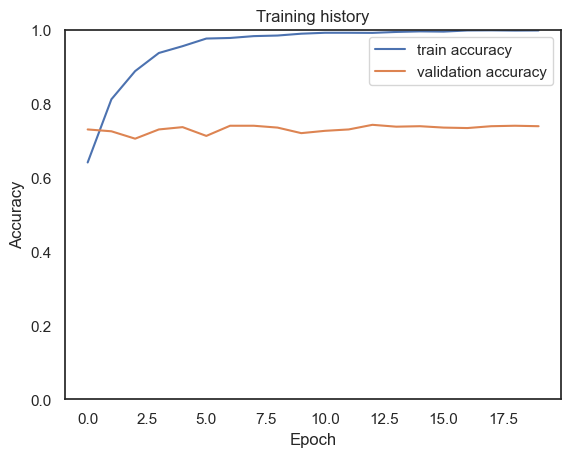

In [ ]:
sns.set_theme(style="white", palette=None)
plt.plot(train_acc, label='train accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

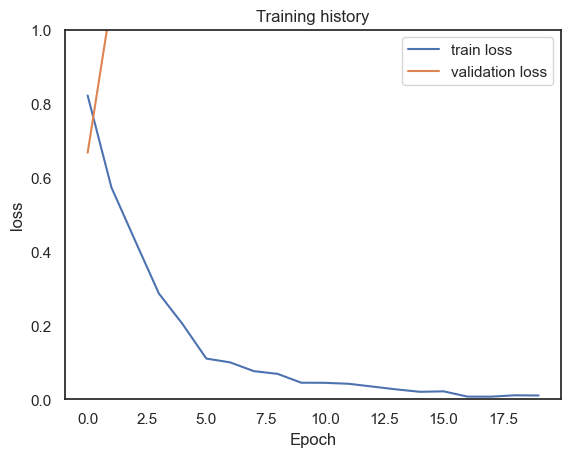

In [ ]:
sns.set_theme(style="white", palette=None)
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
model = ABSA_Model()
model.load_state_dict(torch.load(f'{conf.model_save_path}/best_model_state.bin'))
model = model.to(device)

RuntimeError: Error(s) in loading state_dict for ABSA_Model:
	Unexpected key(s) in state_dict: "bert_model.embeddings.position_ids". 

In [ ]:
# accuracy on the test set 
test_acc, _ = eval_fn(model, val_dataloader, loss_fn, device, len(df_val))
print(test_acc.item())

0.7425


In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']

In [ ]:
def get_predictions(model, data_loader):
    
    model = model.eval()

    texts = []
    aspects = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for data in data_loader:

            texts_ = data["text"]
            aspects_ = data["aspect"]
            input_ids = data["input_ids"].to(device)
            attention_mask = data["attention_mask"].to(device)
            targets = data["targets"].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs, dim=1)

            texts.extend(texts_)
            aspects.extend(aspects_)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return texts, aspects, predictions, prediction_probs, real_values

In [ ]:
y_texts, y_aspects, y_pred, y_pred_probs, y_test = get_predictions(model, val_dataloader)

In [ ]:
# this is the accuracy given by model trained on GTX 1650 4GB.
# The best accuracy model is present in C./models/best_model_state.bin with ~96% acc.

print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    Negative       0.74      0.82      0.78       336
     Neutral       0.72      0.72      0.72       259
    Positive       0.80      0.64      0.71       205

    accuracy                           0.74       800
   macro avg       0.75      0.73      0.73       800
weighted avg       0.75      0.74      0.74       800



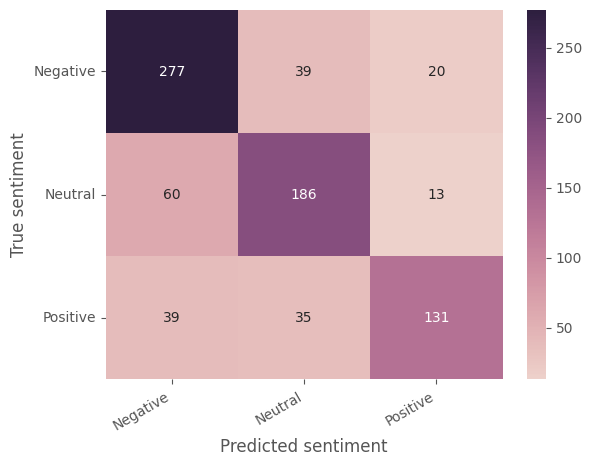

In [ ]:
def show_confusion_matrix(confusion_matrix):
    
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap=sns.cubehelix_palette(as_cmap=True))
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment')
    
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

In [ ]:
idx = 4

text = y_texts[idx]
aspect = y_aspects[idx]
true_sentiment = y_test[idx]
pred_df = pd.DataFrame({
  'class_names': class_names,
  'values': y_pred_probs[idx]
})

print("\n".join(wrap(text)))
print("\n".join(wrap(aspect)))
print()
print(f'True sentiment: {class_names[true_sentiment]}')

app on the ios terribly slow crashes multiple times does not support
apple pencil
App

True sentiment: Positive


#### Predicting on raw text

In [ ]:
text = "cannot rely on both milk delivery and grocery items"
aspect = "Milk"

In [ ]:
encoded_text = tokenizer(
      text,
      aspect,
      add_special_tokens = True,
      max_length = conf.MAX_LEN,
      return_token_type_ids = False,
      padding = 'max_length',
      truncation = True,
      return_attention_mask = True,
      return_tensors = 'pt',
    )

In [ ]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

In [ ]:
print(f'text: {text}')
print(f'aspect: {aspect}')
print(f'Sentiment  : {class_names[prediction]}')

text: cannot rely on both milk delivery and grocery items
aspect: Milk
Sentiment  : Negative


#### Saving the accuracies and losses

In [ ]:
import pickle

In [ ]:
conf.results_save_path

'c:\\Users\\mohsi\\OneDrive\\Desktop\\Aspect-Based-Sentiment-Extraction/data/results'

In [ ]:
with open(f"{conf.results_save_path}/train_acc.txt", "wb") as fp:  
    pickle.dump(train_acc, fp)

In [ ]:
with open(f"{conf.results_save_path}/val_acc.txt", "wb") as fp:  
    pickle.dump(val_acc, fp)

In [ ]:
with open(f"{conf.results_save_path}/train_loss.txt", "wb") as fp:   
    pickle.dump(history['train_loss'], fp)

In [ ]:
with open(f"{conf.results_save_path}/val_loss.txt", "wb") as fp:   
    pickle.dump(history['val_loss'], fp)

### Evaluation on the provided test file

In [ ]:
device = conf.device
device
#device = torch.device('cpu')

device(type='cuda')

In [ ]:
conf.model_save_path

'c:\\Users\\mohsi\\OneDrive\\Desktop\\Aspect-Based-Sentiment-Extraction/models'

In [ ]:
model = ABSA_Model()
model.load_state_dict(torch.load(f'{conf.model_save_path}/best_model_state.bin'))
model = model.to(device)

In [ ]:
class_names = ['Negative', 'Neutral', 'Positive']